<a href="https://colab.research.google.com/github/AshbeeKim/Summarizaion_and_Minutes/blob/main/UtilizeDBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster

## 군집화를 위한 기본 원칙

1. All points within the cluster are mutually density-connected.
2. If a point is density-reachable from some point of the cluster, it is part of the cluster as well.

## 군집의 종류

* K-Means
* Affinity Propagation
* Mean Shift
* Spectral clustering
* Hierarchical clustering
* DBSCAN
* OPTICS
* BIRCH

etc.


[Category:Cluster analysis algorithms] https://en.wikipedia.org/wiki/Category:Cluster_analysis_algorithms

[SCIKIT-LEARN : Clustering] https://scikit-learn.org/stable/modules/clustering.html#dbscan

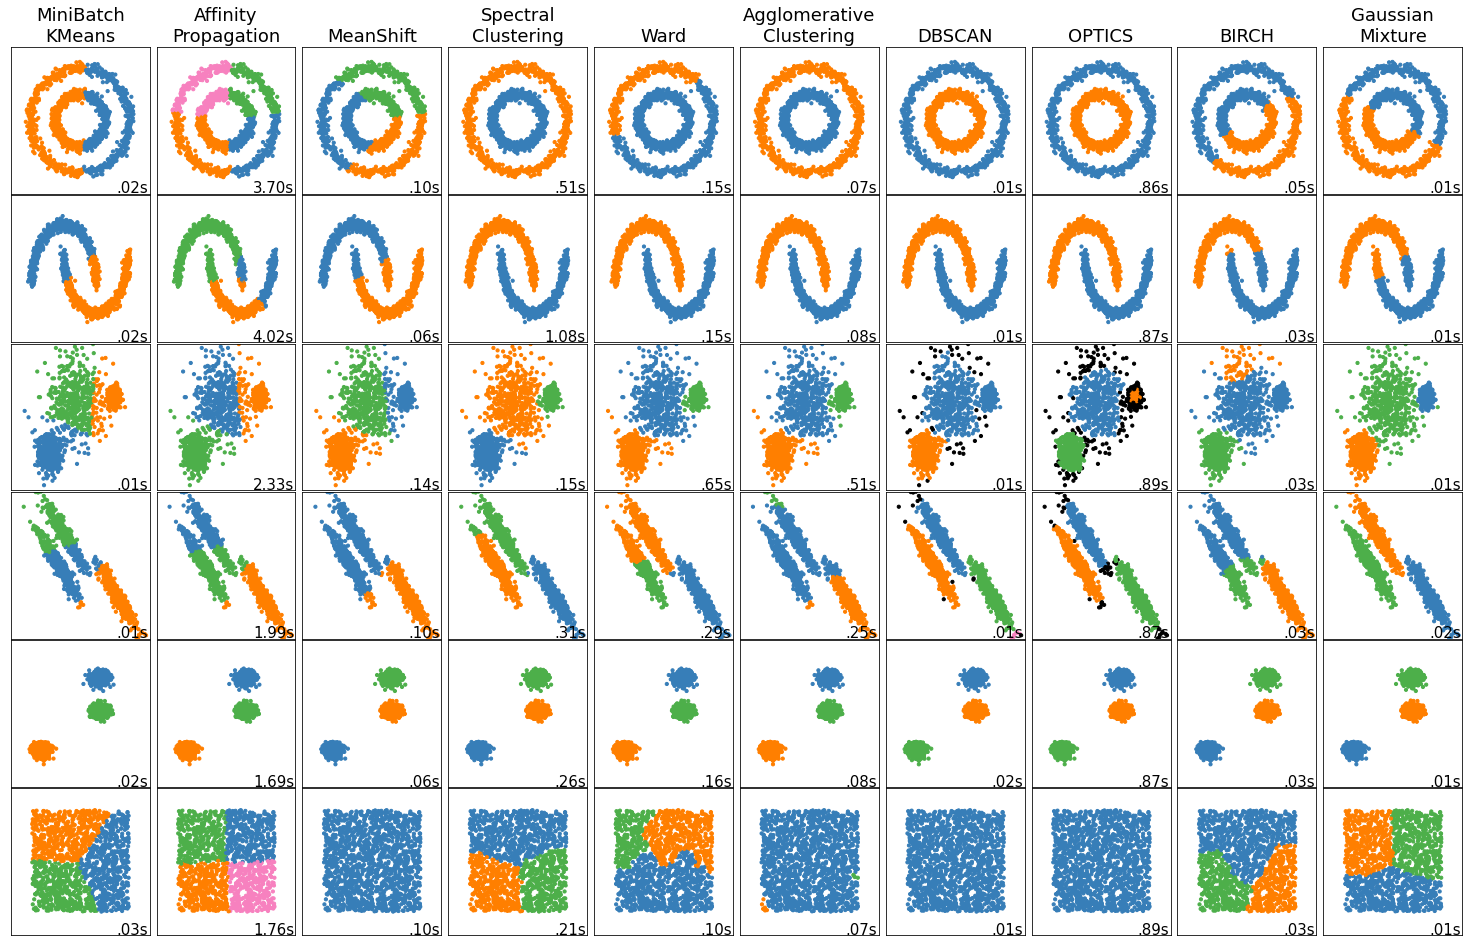

## plot 코드(scikit-learn document 참고)



```
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()
```



## 군집 분석의 목적

군집 분석은 속성의 거리, 밀도 등을 확인해서 유사 속성으로 그룹핑하는 탐색적 다변량 분석기법이다.

크게 분류하자면,

* 계층적 군집 분석
* 비계층적 군집 분석

으로 나눌 수 있는데, 자료의 크기나 군집의 수, 데이터의 형태에 따라서 방법의 차이가 존재한다.


비계층적 군집 분석에 해당되기 때문에, 계층 구조까지 반영해야하는 복잡한 데이터의 경우 DBSCAN으로 풀이하는 것을 지양한다.

* AffinityPropagation

주식 시장 구조에 대한 코드 예시로 DBSCAN이 아닌 AffinityPropagation이 사용된 이유를 고민해보면 알 수 있음

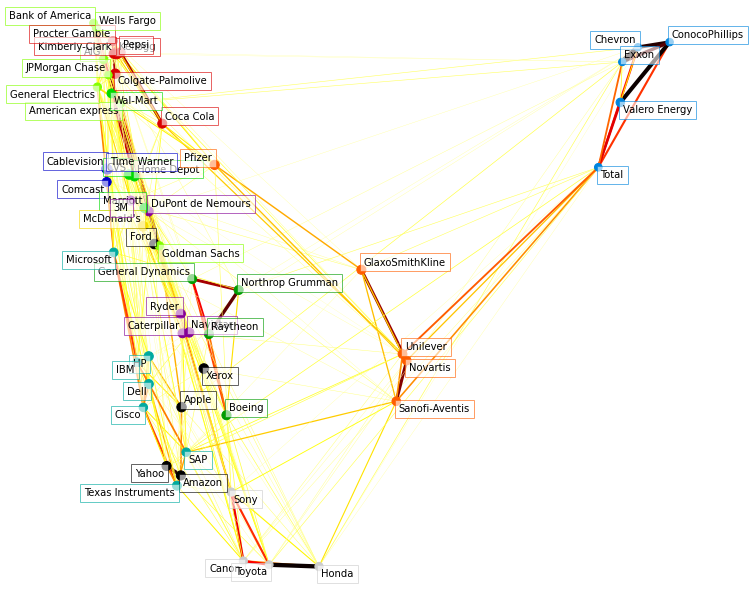

## plot 코드 참고(scikit learn)

https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py

In [ ]:
# # Author: Gael Varoquaux gael.varoquaux@normalesup.org
# # License: BSD 3 clause

# import sys

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection

# import pandas as pd

# from sklearn import cluster, covariance, manifold
# from sklearn.cluster import AffinityPropagation
# print(__doc__)


# # #############################################################################
# # Retrieve the data from Internet

# # The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# # that we get high-tech firms, and before the 2008 crash). This kind of
# # historical data can be obtained for from APIs like the quandl.com and
# # alphavantage.co ones.

# symbol_dict = {
#     'TOT': 'Total',
#     'XOM': 'Exxon',
#     'CVX': 'Chevron',
#     'COP': 'ConocoPhillips',
#     'VLO': 'Valero Energy',
#     'MSFT': 'Microsoft',
#     'IBM': 'IBM',
#     'TWX': 'Time Warner',
#     'CMCSA': 'Comcast',
#     'CVC': 'Cablevision',
#     'YHOO': 'Yahoo',
#     'DELL': 'Dell',
#     'HPQ': 'HP',
#     'AMZN': 'Amazon',
#     'TM': 'Toyota',
#     'CAJ': 'Canon',
#     'SNE': 'Sony',
#     'F': 'Ford',
#     'HMC': 'Honda',
#     'NAV': 'Navistar',
#     'NOC': 'Northrop Grumman',
#     'BA': 'Boeing',
#     'KO': 'Coca Cola',
#     'MMM': '3M',
#     'MCD': 'McDonald\'s',
#     'PEP': 'Pepsi',
#     'K': 'Kellogg',
#     'UN': 'Unilever',
#     'MAR': 'Marriott',
#     'PG': 'Procter Gamble',
#     'CL': 'Colgate-Palmolive',
#     'GE': 'General Electrics',
#     'WFC': 'Wells Fargo',
#     'JPM': 'JPMorgan Chase',
#     'AIG': 'AIG',
#     'AXP': 'American express',
#     'BAC': 'Bank of America',
#     'GS': 'Goldman Sachs',
#     'AAPL': 'Apple',
#     'SAP': 'SAP',
#     'CSCO': 'Cisco',
#     'TXN': 'Texas Instruments',
#     'XRX': 'Xerox',
#     'WMT': 'Wal-Mart',
#     'HD': 'Home Depot',
#     'GSK': 'GlaxoSmithKline',
#     'PFE': 'Pfizer',
#     'SNY': 'Sanofi-Aventis',
#     'NVS': 'Novartis',
#     'KMB': 'Kimberly-Clark',
#     'R': 'Ryder',
#     'GD': 'General Dynamics',
#     'RTN': 'Raytheon',
#     'CVS': 'CVS',
#     'CAT': 'Caterpillar',
#     'DD': 'DuPont de Nemours'}


# symbols, names = np.array(sorted(symbol_dict.items())).T

# quotes = []

# for symbol in symbols:
#     print('Fetching quote history for %r' % symbol, file=sys.stderr)
#     url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
#            'master/financial-data/{}.csv')
#     quotes.append(pd.read_csv(url.format(symbol)))

# close_prices = np.vstack([q['close'] for q in quotes])
# open_prices = np.vstack([q['open'] for q in quotes])

# # The daily variations of the quotes are what carry most information
# variation = close_prices - open_prices


# # #############################################################################
# # Learn a graphical structure from the correlations
# edge_model = covariance.GraphicalLassoCV()

# # standardize the time series: using correlations rather than covariance
# # is more efficient for structure recovery
# X = variation.copy().T
# X /= X.std(axis=0)
# edge_model.fit(X)

# # #############################################################################
# # Cluster using affinity propagation

# af = AffinityPropagation().fit(edge_model.covariance_)
# labels = af.labels_
# # _, labels = AffinityPropagation(edge_model.covariance_, random_state=0)
# n_labels = labels.max()

# for i in range(n_labels + 1):
#     print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# # #############################################################################
# # Find a low-dimension embedding for visualization: find the best position of
# # the nodes (the stocks) on a 2D plane

# # We use a dense eigen_solver to achieve reproducibility (arpack is
# # initiated with random vectors that we don't control). In addition, we
# # use a large number of neighbors to capture the large-scale structure.
# node_position_model = manifold.LocallyLinearEmbedding(
#     n_components=2, eigen_solver='dense', n_neighbors=6)

# embedding = node_position_model.fit_transform(X.T).T

# # #############################################################################
# # Visualization
# plt.figure(1, facecolor='w', figsize=(10, 8))
# plt.clf()
# ax = plt.axes([0., 0., 1., 1.])
# plt.axis('off')

# # Display a graph of the partial correlations
# partial_correlations = edge_model.precision_.copy()
# d = 1 / np.sqrt(np.diag(partial_correlations))
# partial_correlations *= d
# partial_correlations *= d[:, np.newaxis]
# non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# # Plot the nodes using the coordinates of our embedding
# plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
#             cmap=plt.cm.nipy_spectral)

# # Plot the edges
# start_idx, end_idx = np.where(non_zero)
# # a sequence of (*line0*, *line1*, *line2*), where::
# #            linen = (x0, y0), (x1, y1), ... (xm, ym)
# segments = [[embedding[:, start], embedding[:, stop]]
#             for start, stop in zip(start_idx, end_idx)]
# values = np.abs(partial_correlations[non_zero])
# lc = LineCollection(segments,
#                     zorder=0, cmap=plt.cm.hot_r,
#                     norm=plt.Normalize(0, .7 * values.max()))
# lc.set_array(values)
# lc.set_linewidths(15 * values)
# ax.add_collection(lc)

# # Add a label to each node. The challenge here is that we want to
# # position the labels to avoid overlap with other labels
# for index, (name, label, (x, y)) in enumerate(
#         zip(names, labels, embedding.T)):

#     dx = x - embedding[0]
#     dx[index] = 1
#     dy = y - embedding[1]
#     dy[index] = 1
#     this_dx = dx[np.argmin(np.abs(dy))]
#     this_dy = dy[np.argmin(np.abs(dx))]
#     if this_dx > 0:
#         horizontalalignment = 'left'
#         x = x + .002
#     else:
#         horizontalalignment = 'right'
#         x = x - .002
#     if this_dy > 0:
#         verticalalignment = 'bottom'
#         y = y + .002
#     else:
#         verticalalignment = 'top'
#         y = y - .002
#     plt.text(x, y, name, size=10,
#              horizontalalignment=horizontalalignment,
#              verticalalignment=verticalalignment,
#              bbox=dict(facecolor='w',
#                        edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
#                        alpha=.6))

# plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
#          embedding[0].max() + .10 * embedding[0].ptp(),)
# plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
#          embedding[1].max() + .03 * embedding[1].ptp())

# plt.show()

## DBSCAN

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/800px-DBSCAN-Illustration.svg.png"/>

자세한 수식은 강사님의 수업 자료에 있기 때문에, 이해한 내용을 바탕으로 DBSCAN에 대해 정의를 내리자면, cluster의 수를 정하지 않아도 되고 밀도별 군집화라 기하학적 모양을 가진 군집도 찾을 수 있다. Noise Point를 통한, Outlier 검출도 가능하지만 실제 데이터를 활용하면 치명적인 단점이 존재한다고 판단했다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/DBSCAN-density-data.svg/440px-DBSCAN-density-data.svg.png"/>

DBSCAN 이전의 Hierachical Clustering은 매 단계에서 local minimum를 찾아가는 방법을 사용하기에 결과가 global minimum이라고 볼 수 없다.

DBSCAN이 계층 구조를 반영하지 못한다는 단점이 존재함에도, eps_neighbors와 MinPts를 사용해 군집을 구성하기에 noise와 outlier에 민감하지 않고, 원형이 아닌 데이터의 군집도 분류할 수 있다는 장점이 있기에 차원 축소를 해서라도 global minimum을 찾는 방법을 채택한 경우가 많다.

* eps : 

* min_samples : 

* metric : default='euclidean'
* metric_params : default=None
* algorithm : default='auto'
* leaf_size : default=30
* p : default=None
* n_jobs : defalut=None

Attributes

* core_sample_indices_ : ndarray of shape (n_core_samples,)
* components_ : ndarray of shape (n_core_samples, n_features)
* labels_ : ndarray of shape(n_samples)__ nosiy samples are given the label -1

[DBSCAN] https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

계층 구조를 반영할 방법으로는 OPTICS과 HDBSCAN가 있다.

OPTICS : A similar clustering at multiple values of eps. Our implementation is optimized for memory usage.
OPTICS의 파라미터 중 cluster_method를 'dbscan'으로 설정하면 dbscan의 방식으로 풀 수 있고, default인 'xi'로 설정하면 cluster_hierarchy_라는 attribtes에 접근이 가능하다.
(OPTICS에 대한 자세한 설명은 다른 분께서 설명을 해주실 듯)

In [ ]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 22.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311850 sha256=e481cd2be1602fb1e88c0f6a969be6cbdebfc4cbabb788bafac4d1cdf7c46027
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
import hdbscan

* HDBSCAN
* [ADBSCAN: Adaptive Density-Based Spatial Clustering of Applications with Noise for Identifying Clusters with Varying Densities] https://arxiv.org/pdf/1809.06189.pdf
* [DBSCAN++: Towards fast and scalable density clustering] https://arxiv.org/pdf/1810.13105.pdf
* [Theoretically-Efficient and Practical Parallel DBSCAN] https://arxiv.org/pdf/1912.06255.pdf
* [KNN-DBSCAN:A DBSCAN IN HIGH DIMENSIONS] https://arxiv.org/pdf/2009.04552.pdf
* [Fast tree-based algorithms for DBSCAN on GPUs] https://arxiv.org/pdf/2103.05162.pdf